# 9.1. Implementing a Feed-Forward-Network

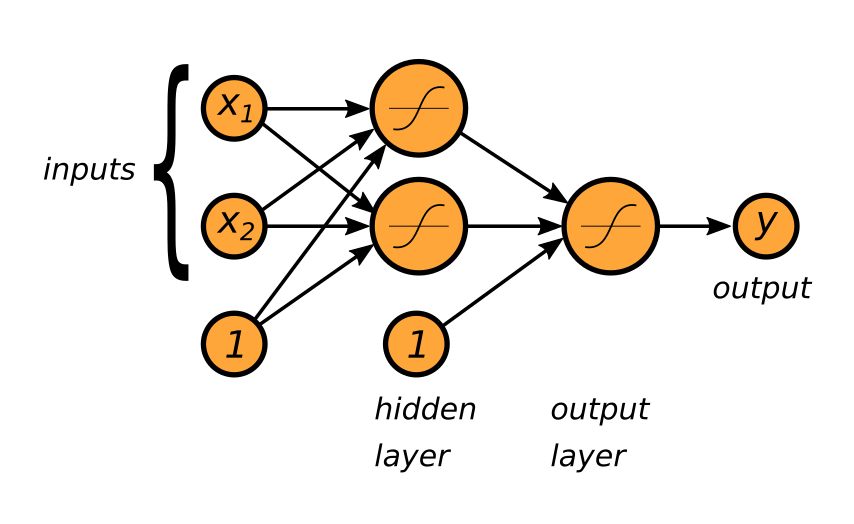

### Import 

In [1]:
from sklearn.datasets import make_moons
import tensorflow
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Creating training data

In [2]:
X, y = make_moons(n_samples=50, noise=0.15, random_state=42)

### Step 2: Plotting the data

Creating a scatterplot of the 2 columns of X data.
Coloring the data points according to the labels (y).

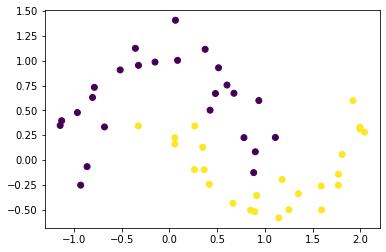

In [3]:
plt.scatter(X[:,0], X[:,1], c=y)

### Step 3: Adding a bias (parameter b) column to X

Since we are modeling our data set with a bias (all ones), we need to add a third column to our X array.

Use NumPy to “horizontally stack” an extra column for the bias onto your input.

Additionally, write a python function add_bias, that accepts a NumPy array as an input, and returns a NumPy array with an extra column of ones.

In [4]:
X.shape[0]

50

In [5]:
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

### Step 4: calculating the sigmoid activation function

In our simple feed-forward network, we’ll be using the sigmoid activation function for all 3 of our neurons.

Write a python function, sigmoid, that accepts a NumPy array as an input, and returns a NumPy array where all of the original values have been transformed by the sigmoid / logistic function.

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [7]:
# You’ll know if you wrote it correctly if the following code doesn’t throw an assertion error:
a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

### Step 5: Initializing the weights

Refer again to the image of network we’re trying to build. What about all the neural connections / arrows? Those are our weights.

These weights should also be represented by NumPy arrays, since they will multiplied (i.e. dot product) by input values before getting passed into an activation function.

Initialize the network with random weights (for both the hidden and output layers).

Hint (questions to help guide you):
- In our simple network, how many weights should we have, in total?
- How many weights are in the hidden layer, and how many in the output layer?
- If we represent the weights for each layer with a separate numpy array, what should its shape be, given that – for example – the first layer has 3 inputs that feed 2 neurons?

In [8]:
# number of neurons (input, first hidden layer)
n_neurons = 2

In [9]:
weights = []
weights.append(np.random.randn(X.shape[1], n_neurons)) # between innput and hidden
weights.append(np.random.randn(n_neurons+1, 1)) # between hidden and output

In [10]:
weights

[array([[ 0.59656218,  0.17236694],
        [ 0.7967056 , -1.14899255]]),
 array([[-0.77774039],
        [ 0.43776662],
        [ 1.3585076 ]])]

### Step 6: Connect all the pieces and “build” the network!

Wrap everything into a python function that “runs” the feed-forward network from beginning to end one time. This function should accept the input data as an argument, as well as the initial random weights.

In the annotated template code below, the weights are assumed to be a single argument (e.g. a list of a NumPy arrays), but this of course could be split into separate arguments.

In [11]:
def feed_forward(X, weights):

    """
    1. Multiply the input matrix X (shape of (50, 3))
       with the weights of the first layer (shape of (3, 2)),
       resulting in the matrix of the shape (50, 2)
    """
    step1 = np.dot(X, weights[0]) 

    """    
    2. Apply the sigmoid function on the result,
       preserving the shape (50, 2) 
    """
    step2 = sigmoid(step1)
    
    """    
    3. Append an extra column of ones to the result (i.e. the bias),
       resulting in the shape (50, 3)
    """
    step3 = add_bias(step2)

    """    
    4. Multiply the output of the previous step (shape of (50, 3))
       with the weights of the second (i.e. outer) layer (shape of (3, 1)),
       resulting in the shape (50, 1)
    """
    step4 = np.dot(step3, weights[1])
    
    """    
    5. Apply the sigmoid function on the result, shape remains (50, 1)
    """
    step5 = sigmoid(step4)
    
    """    
    6. Return all intermediate results (i.e. anything that
       an activation function outputs).
    """

    return step2, step5

And test it (note, you may have to change the names slightly):

In [12]:
out1, out2 = feed_forward(X, weights)

In [13]:
out1, out2 = feed_forward(X, weights)
assert out1.shape == (50, 2)
assert out2.shape == (50, 1)

Xref = np.array([[1.0, 2.0, 1.0]])
whidden = np.array([[1.0, 2.0, 0.0],
                 [-1.0, -2.0, 0.0]
                    ]).T
wout = np.array([[1.0, -1.0, 0.5]]).T

out1, out2 = feed_forward(Xref, [whidden, wout])
assert np.all(out1.round(2) == np.array([[0.99, 0.01]]))
assert np.all(out2.round(2) == np.array([[0.82]]))

# 9.2. Backpropagation

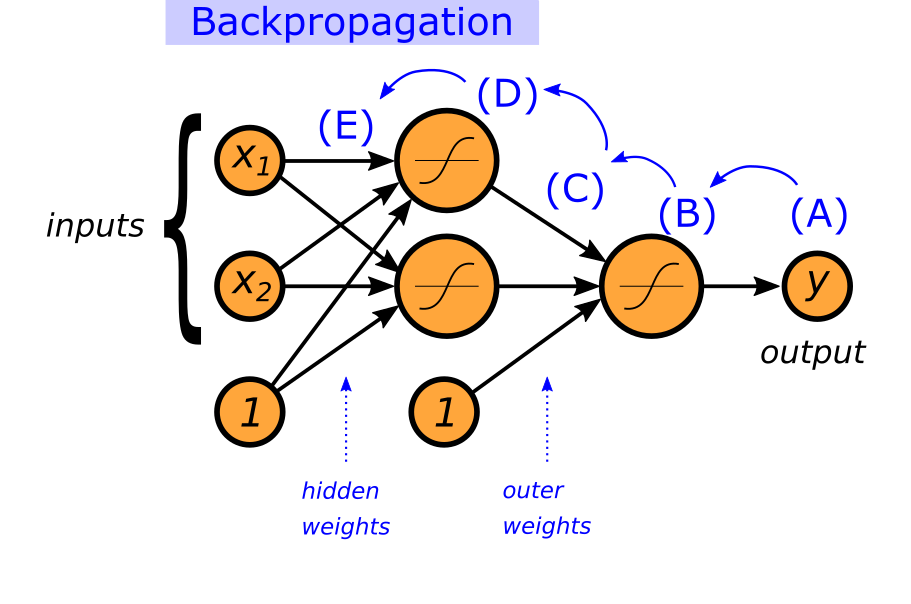

### Step 1: Debugging Check

Run your code for the Feed-Forward-Network and make sure it works. This guide assumes that:

- you’ve already created a function called sigmoid and add_bias.

- you’ve already added a bias to the input data (i.e. a column of 1s) so that X is already coming in with a shape of (N, 3).

- you’re passing in your weights as a single argument (e.g. a list of arrays, or a tuple of arrays, or something similar.

In [14]:
out1, out2 = feed_forward(X, weights)

### Step 2: The derivative of the sigmoid activation function

There’s a neat little property about the sigmoid activation function that is very nice to work with! Essentially, the derivative of the sigmoid of something evaluates to the sigmoid of that something, multiplied by (1 minus the sigmoid of that something).

Let’s write a helper function which performs the steps for us so we don’t have to remember that later:

In [15]:
def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

### Step 3. Write a Loss Function and its derivative

In the gradient descent lesson earlier in the course, we used the mean-squared-error (MSE) as our loss function, which we wanted to minimize. In this case, however, because we are doing a classification problem with a sigmoid activation function as the final layer, we won’t use MSE, but rather the log-loss that you know from week 2.

The function should take the true output and a predicted probability and return the log loss values over each data point:

In [16]:
def log_loss(ytrue, ypred):
    ''' return the log loss'''
    loss = -(ytrue*np.log(ypred)+(1-ytrue)*np.log(1-ypred)) 
    return loss

If you think you filled it in correctly, try out the following code block to verify that that it works as intended!

In [17]:
ytrue = np.array([0.0, 0.0, 1.0, 1.0])
ypred = np.array([0.01, 0.99, 0.01, 0.99])
expected = np.array([0.01, 4.61, 4.61, 0.01])
assert np.all(log_loss(ytrue, ypred).round(2) == expected)

We also need the derivative of the loss with respect to ypred. To make our lifes easier, let’s also code a function for that:

In [18]:
def log_loss_deriv(ytrue, ypred):
    loss_deriv = -(ytrue/ypred - (1-ytrue)/(1-ypred))
    return loss_deriv

In [19]:
a = np.array([0.5, 0.3, 0.99, 0.2])
b = np.array([0.4, 0.2, 0.10, 0.3])
expected = np.array([-0.42, -0.62, -9.89, 0.48])
assert np.all(log_loss_deriv(a, b).round(2) == expected)

### Step 4: Get Initial Loss

Run your feed-forward function, and try getting an array of log-loss values for each of your data points, compared to the actual labels. Note that you’ll need to reshape the ytrue values from a (N, ) array to a (N, 1) array (e.g. both the prediction and the actual values should be (50,1)). Make sure the shape of the loss values is also (N,1).

In [20]:
out1, out2 = feed_forward(X, weights)
ytrue = y.reshape(-1, 1)

In [21]:
loss = log_loss(ytrue, out2)

In [22]:
ytrue.shape

(50, 1)

In [23]:
out2.shape

(50, 1)

In [24]:
loss.shape

(50, 1)

In [25]:
# [print(a, b, c) for (a, b, c) in zip(out2, ytrue, loss)]

### Step 5.  Write a backpropagation function

Fill in the blanks of the following function, which transcribes the equations from earlier (equations A - E) to run one iteration of the backpropagation algorithm. It takes in a handful of arguments:

* the initial weights,
* the outputs from the feed-forward process (i.e. both the hidden output and the final output),
* the true labels,
* the input data,
* and the learning rates (we’ll have a separate learning rate for each layer of the network).

The function (representing a single iteration of the backpropagation algorithm), should **return the modified hidden weights and the modified outer weights.**

In [26]:
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(ytrue, output2)
    
    '''EQUATION B:'''
    #don't forget the bias!
    hidden_out_with_bias = add_bias(output1)
    #derivative of the sigmoid function with respect to the
    #hidden output * weights
    sig_deriv_1 = sigmoid_deriv(hidden_out_with_bias.dot(wO))
    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wO = -np.dot(y_grad.T, hidden_out_with_bias) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wO.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv(X_input.dot(wH))
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = sig_deriv_2 * np.dot(y_grad , wO[:-1].T)
    
    '''EQUATION E:'''
    delta_wH = -np.dot(H_grad.T, X_input) * LR
    #old weights + delta weights -> new weights!
    wH_new = wH + delta_wH.T
    
    # new hidden weights, new output weights
    return wH_new, wO_new

### Step 6: Run the Backpropagation Algorithm

Run your backpropagation algorithm in a loop! Inside the loop:

- Run your feed-forward function with the X data and the starting weights (which are initially random!).
- Collect the total sum of the log-loss values into a list, so we can track them over time.
- Run your backprop function to get the modified weights.
- At the end of the loop, make your modified weights the new weights for the next cycle.

In [27]:
# - increase the number of neurons to see how the performance of your NN changes
# - change the value for learning rate in backprop to see how your model performance changes

LR = 0.01
n_neurons = 5
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.randn(3, n_neurons),
   np.random.randn(n_neurons+1, 1)
]

# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(log_loss(y, out2).sum())
    new_weights = backprop(weights, out1, out2, y, X, LR)
    weights = new_weights

### Step 7: Plotting results

#### 6a: Plot loss function

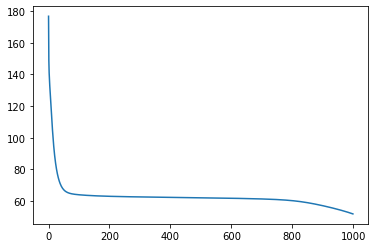

In [28]:
plt.plot(LOSS_VEC)

#### 6a: Plot decision boundary

In [29]:
# create a grid of values
x = np.linspace(-3, 3, 200)
X_vis = np.array([(x1, x2) for x1 in x for x2 in x])
# add the bias column
X_vis = add_bias(X_vis)

# calculate the (random) predictions
_, y_pred = feed_forward(X_vis, weights)

In [30]:
# reshape the predictions for visualization
Z = y_pred.reshape((len(x), len(x)), order='F')

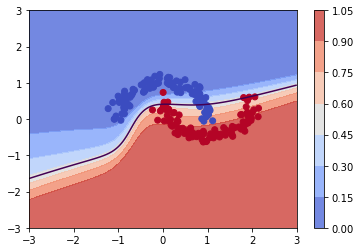

In [62]:
# draw a contour plot
fig,ax=plt.subplots(1,1)
cp = ax.contourf(x, x, Z, alpha=0.8, cmap='coolwarm')
ax.contour(x, x, Z, levels=[0.5])
fig.colorbar(cp) # Add a colorbar to a plot

# draw the original data
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')